In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ssd-weights/ssdmodeldict (2).pth
/kaggle/input/faster-rcnn-weights/fasterrcnnogmodel_state_dict.pth
/kaggle/input/yolo-losses/val loss.csv
/kaggle/input/yolo-losses/train loss.csv
/kaggle/input/ssd-and-faster-rcnn-loss/loss_values (1).txt
/kaggle/input/ssd-and-faster-rcnn-loss/loss_history (2).json
/kaggle/input/anti-uav-yolo-1024/valid/labels/01028.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01484.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00588.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00286.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00080.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01279.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00440.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02557.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01936.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00733.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00134.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01466.txt
/kaggle/input/

In [2]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

In [3]:
from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

import glob
import cv2
from PIL import Image

In [4]:
BASE_PATH = "/kaggle/input/anti-uav-yolo-1024/train"
TXT_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/labels/*.txt")
IMG_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/images/*.jpg")

In [5]:
def convert_format(box, iwidth=1024, iheight=1024):
    x_center, y_center, width, height = box
    
    x_min = int((x_center - width / 2) * iwidth)
    y_min = int((y_center - height / 2) * iheight)
    x_max = int((x_center + width / 2) * iwidth)
    y_max = int((y_center + height / 2) * iheight)
    
    return [x_min, y_min, x_max, y_max]

In [6]:
import os
from PIL import Image

train_image = []
train_image_path = []
train_image_id = []
train_annotation = []

for img_path in IMG_PATH:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/train/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((258, 258))
            train_image.append(np.asarray(nmpy_img))
            train_image_path.append(img_path)
            train_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                train_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")

Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00639.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00724.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00579.jpg
Images and annotations processed successfully.


In [7]:
df = pd.DataFrame()
df['boxes'] = train_annotation
df['img_path'] = train_image_path
df['labels'] = 'drone'
df['img_id'] = train_image_id

In [8]:
import numpy as np
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['labels'])
df['labels'] = np.stack([df['labels'][i]+1 for i in range(len(df['labels']))])

In [9]:
import numpy as np

# Assuming df['boxes'] contains arrays/lists of coordinates
# Create separate columns for 'xmin', 'ymin', 'xmax', 'ymax'
df[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(float)
df['ymin'] = df['ymin'].astype(float)
df['xmax'] = df['xmax'].astype(float)
df['ymax'] = df['ymax'].astype(float)

In [10]:
df_removed_damaged1 = df.drop(df[(df.ymin > df.ymax) | (df.xmin > df.xmax)].index)
df_removed_damaged1

mask = (df['ymin'] > 1024) | (df['ymax'] > 1024) | (df['xmin'] > 1024) | (df['xmax'] > 1024)
# Drop rows where the condition is True
df_removed_damaged = df_removed_damaged1.drop(df[mask].index)

In [11]:
train_ds=df_removed_damaged[:4000]
val_ds=df_removed_damaged[4000:]
train_ds

,img_path,labels,img_id,xmin,ymin,xmax,ymax
0,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,04168,566.0,703.0,580.0,714.0
1,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02371,296.0,360.0,318.0,383.0
2,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,04377,469.0,381.0,481.0,390.0
3,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,00767,576.0,594.0,682.0,716.0
4,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02360,361.0,352.0,388.0,381.0
...,...,...,...,...,...,...,...
3995,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02303,607.0,420.0,627.0,436.0
3996,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02648,477.0,747.0,500.0,775.0
3997,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,03674,322.0,659.0,340.0,678.0
3998,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02833,192.0,858.0,242.0,900.0


In [12]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.resize(image, (1024, 1024))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        if len(boxes) == 0:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'image_id': torch.tensor([index]),
                'area': torch.zeros(0, dtype=torch.float32),
                'iscrowd': torch.zeros(0, dtype=torch.int64)
            }
        else:

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            label = records['labels'].values
            labels = torch.as_tensor(label, dtype=torch.int64)

            # Suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([index]),
                'area': area,
                'iscrowd': iscrowd
            }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

            # Only stack the boxes if there are non-empty bounding boxes
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [13]:
def get_transform_train():
    return A.Compose([
        #A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = TrainDataset(train_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_train())
valid_dataset = TrainDataset(val_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_train())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 9.6 MB/s eta 0:00:00:00:01


# **SSD**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

In [18]:
model_weights_pth="/kaggle/input/ssd-weights/ssdmodeldict (2).pth"
model=ssd300_vgg16()
num_classes=2
in_channels=det_utils.retrieve_out_channels(model.backbone,(1024,1024))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_weights_pth,map_location=device))
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:03<00:00, 175MB/s]  


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [19]:
from torchmetrics.detection import MeanAveragePrecision
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

MeanAveragePrecision()

In [20]:
threshold=0.25
iou_threshold=0.75
iou=10
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [21]:
model.eval()
with torch.no_grad():
    for imgs,targets in valid_data_loader:
        imgs=[img.to(device) for img in imgs]
        #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        predictions=model(imgs)
        
        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
        
        metric.update(results,targets)
        
results=metric.compute()

In [22]:
ssd_mean_ap=results["map"].item()*iou
ssd_mean_ap_50=results["map_50"].item()*iou
ssd_mean_ap_75=results["map_75"].item()*iou

print(f"Mean Average Precision[0.5:0.95:0.05] : {ssd_mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {ssd_mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {ssd_mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.1724
Mean Average Precision @ 0.5          : 0.3874
Mean Average Precision @ 0.75         : 0.1248


# **Faster rcnn**

In [23]:
# load  a model; pre-trained on COCO
modelf = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "/kaggle/input/faster-rcnn-weights/fasterrcnnogmodel_state_dict.pth"

num_classes = 2

# get number of input features for the classifier
in_features = modelf.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
modelf.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
modelf.load_state_dict(torch.load(WEIGHTS_FILE))

modelf = modelf.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [24]:
modelf.eval()
with torch.no_grad():
    for imgs,targets in valid_data_loader:
        imgs=[img.to(device) for img in imgs]
        #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        predictions=model(imgs)
        
        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
        
        metric.update(results,targets)
        
results=metric.compute()

In [25]:
fast_mean_ap=results["map"].item()*iou
fast_mean_ap_50=results["map_50"].item()*iou
fast_mean_ap_75=results["map_75"].item()*iou

print(f"Mean Average Precision[0.5:0.95:0.05] : {fast_mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {fast_mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {fast_mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.1570
Mean Average Precision @ 0.5          : 0.3785
Mean Average Precision @ 0.75         : 0.0827


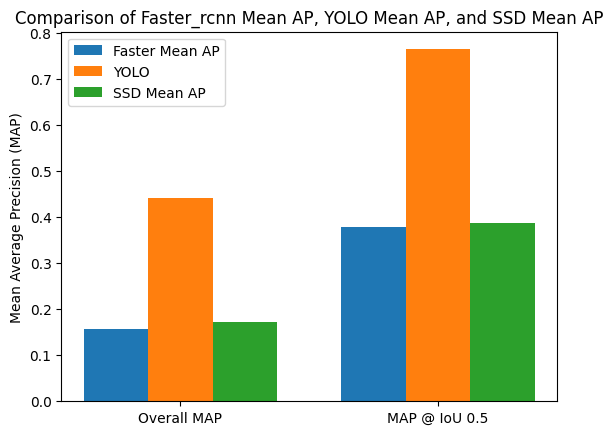

In [26]:
labels = ['Overall MAP', 'MAP @ IoU 0.5']

#fasterrcnn
fast_data = [fast_mean_ap, fast_mean_ap_50]
#yolo
yolo_data=[0.4404360958920952,0.764410426518142]
# SSD Mean AP data
ssd_data = [ssd_mean_ap, ssd_mean_ap_50]


# Width of a bar
x = range(len(labels))

# Width of a bar
width = 0.25

# Plotting the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, fast_data, width, label='Faster Mean AP')
rects2 = ax.bar([p + width for p in x], yolo_data, width, label='YOLO')
rects3 = ax.bar([p + 2*width for p in x], ssd_data, width, label='SSD Mean AP')

# Adding labels, title, and legend
ax.set_ylabel('Mean Average Precision (MAP)')
ax.set_title('Comparison of Faster_rcnn Mean AP, YOLO Mean AP, and SSD Mean AP')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(labels)
ax.legend()

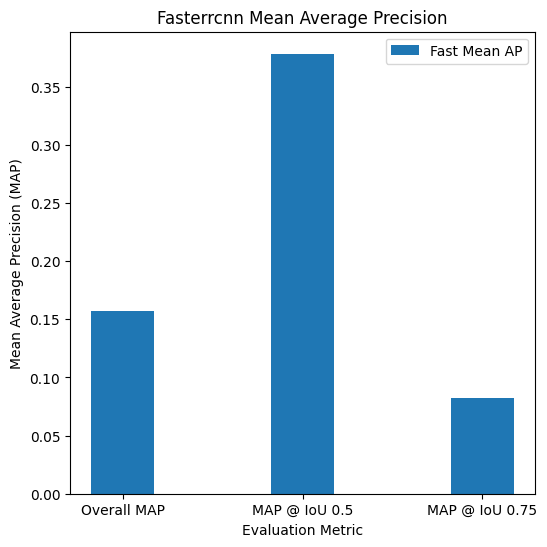

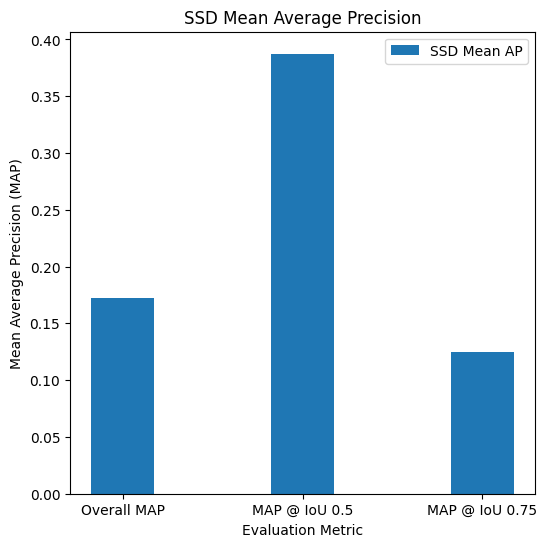

In [27]:
labels = ['Overall MAP', 'MAP @ IoU 0.5', 'MAP @ IoU 0.75']

# Position of bars on x-axis
x = range(len(labels))

# Width of a bar
width = 0.35

# Plotting Fast Mean AP
plt.figure(figsize=(6, 6))
plt.bar(x, [fast_mean_ap, fast_mean_ap_50, fast_mean_ap_75], width, label='Fast Mean AP')
plt.xlabel('Evaluation Metric')
plt.ylabel('Mean Average Precision (MAP)')
plt.title('Fasterrcnn Mean Average Precision')
plt.xticks(x, labels)
plt.legend()
plt.show()

# Plotting SSD Mean AP
plt.figure(figsize=(6, 6))
plt.bar(x, [ssd_mean_ap, ssd_mean_ap_50, ssd_mean_ap_75], width, label='SSD Mean AP')
plt.xlabel('Evaluation Metric')
plt.ylabel('Mean Average Precision (MAP)')
plt.title('SSD Mean Average Precision')
plt.xticks(x, labels)
plt.legend()
plt.show()

In [28]:
import json

# Assuming your JSON file is named "data.json"
file_path = "/kaggle/input/ssd-and-faster-rcnn-loss/loss_history (2).json"

# Load the JSON file
with open(file_path, "r") as file:
    data = json.load(file)

# Now, 'data' variable holds the content of your JSON file
print(data)
ssd_train_loss=data['training_loss']
ssd_val_loss=data['validation_loss']

{'training_loss': [0.6598229030609478, 0.597123425107284, 0.5480482851172186, 0.5252666611115627, 0.4952374567189204, 0.47324482768896725, 0.46030934784575894, 0.4465061719082856, 0.43417804261898524, 0.4242676226934411], 'validation_loss': [1.3149351020647682, 1.2073260930749354, 1.1394386631938087, 1.0821473311581917, 1.0243380990649182, 0.9822531968515149, 0.9434715714782516, 0.9185532596992624, 0.891573891345777, 0.8749830597991561]}


In [29]:
file_path = "/kaggle/input/ssd-and-faster-rcnn-loss/loss_values (1).txt"

# Load the text file
with open(file_path, "r") as file:
    text_data = file.read()
# Now, 'text_data' variable holds the content of your text file
print(text_data)

fast_train_loss= [0.1482902353196245,0.12839949267607678,0.12239842998164037,0.11490442065765374,0.10675544128986053]
fast_val_loss= [0.13660987354262835,0.14213444198008784,0.12176148379633724,0.1135841039851855,0.10653540087843523]


Train Loss
0.1482902353196245
0.12839949267607678
0.12239842998164037
0.11490442065765374
0.10675544128986053

Validation Loss
0.13660987354262835
0.14213444198008784
0.12176148379633724
0.1135841039851855
0.10653540087843523



In [30]:


# Path to the CSV file
csv_file_path = "/kaggle/input/yolo-losses/train loss.csv"
import pandas as pd


# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Print the DataFrame
print(df)
df.columns

   Step  train3 - train/box_loss  train3 - train/box_loss__MIN  \
0     1                  1.97110                       1.97110   
1     2                  2.19919                       2.19919   
2     3                  2.03805                       2.03805   
3     4                  1.95093                       1.95093   
4     5                  1.87086                       1.87086   
5     6                  1.71617                       1.71617   
6     7                  1.64615                       1.64615   
7     8                  1.58824                       1.58824   
8     9                  1.49391                       1.49391   
9    10                  1.42364                       1.42364   

   train3 - train/box_loss__MAX  
0                       1.97110  
1                       2.19919  
2                       2.03805  
3                       1.95093  
4                       1.87086  
5                       1.71617  
6                       1.64615  
7

Index(['Step', 'train3 - train/box_loss', 'train3 - train/box_loss__MIN',
       'train3 - train/box_loss__MAX'],
      dtype='object')

In [34]:
yolo_train_loss = df['train3 - train/box_loss'].tolist()
yolo_val_loss=df2['train3 - val/box_loss'].tolist()
yolo_train_loss
yolo_val_loss=[2.71123,2.91488,
 2.32332,
 2.22223,
 2.01142,
 1.90531,
 1.80032,
 1.66647,
 1.68462,
 1.54292]

In [33]:
# Path to the CSV file
csv_file_path = "/kaggle/input/yolo-losses/val loss.csv"
import pandas as pd


# Read the CSV file into a DataFrame
df2= pd.read_csv(csv_file_path)
mean_value = df2['train3 - val/box_loss'].mean()
df2['train3 - val/box_loss'].fillna(mean_value, inplace=True)

# Print the DataFrame
print(df2)
df2.columns

   Step  train3 - val/box_loss  train3 - val/box_loss__MIN  \
0     1               2.711230                     2.71123   
1     2               2.914880                     2.91488   
2     3               2.323320                     2.32332   
3     4               2.095021                         NaN   
4     5               2.011420                     2.01142   
5     6               1.905310                     1.90531   
6     7               2.095021                         NaN   
7     8               1.666470                     1.66647   
8     9               1.684620                     1.68462   
9    10               1.542920                     1.54292   

   train3 - val/box_loss__MAX  
0                     2.71123  
1                     2.91488  
2                     2.32332  
3                         NaN  
4                     2.01142  
5                     1.90531  
6                         NaN  
7                     1.66647  
8                     1.68462

/tmp/ipykernel_34/2430007546.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['train3 - val/box_loss'].fillna(mean_value, inplace=True)


Index(['Step', 'train3 - val/box_loss', 'train3 - val/box_loss__MIN',
       'train3 - val/box_loss__MAX'],
      dtype='object')

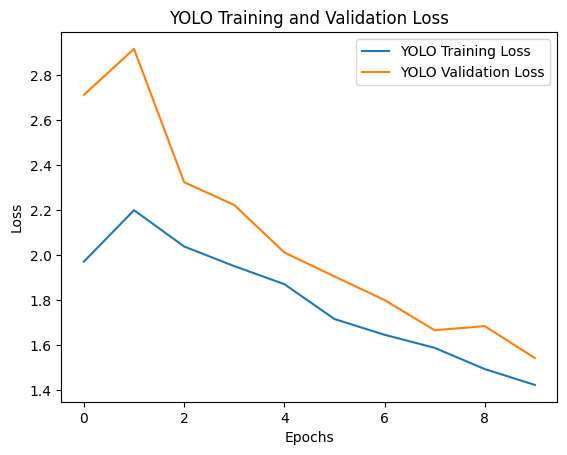

In [35]:
import pandas as pd
import matplotlib.pyplot as plt


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot YOLO training loss
ax.plot(yolo_train_loss, label='YOLO Training Loss')

# Plot YOLO validation loss
ax.plot(yolo_val_loss, label='YOLO Validation Loss')

# Add labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('YOLO Training and Validation Loss')
ax.legend()

# Show the plot
plt.show()

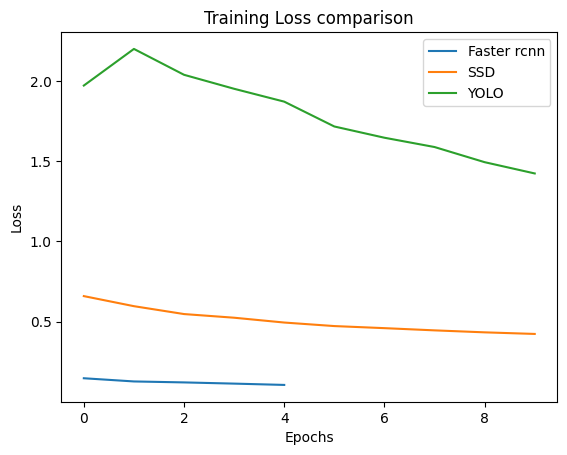

In [36]:
import matplotlib.pyplot as plt
fast_train_loss= [0.1482902353196245,0.12839949267607678,0.12239842998164037,0.11490442065765374,0.10675544128986053]
fast_val_loss= [0.13660987354262835,0.14213444198008784,0.12176148379633724,0.1135841039851855,0.10653540087843523]


# Plotting
plt.plot(fast_train_loss, label='Faster rcnn')
plt.plot(ssd_train_loss, label='SSD')
plt.plot( yolo_train_loss, label='YOLO')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss comparison')
plt.legend()
plt.show()


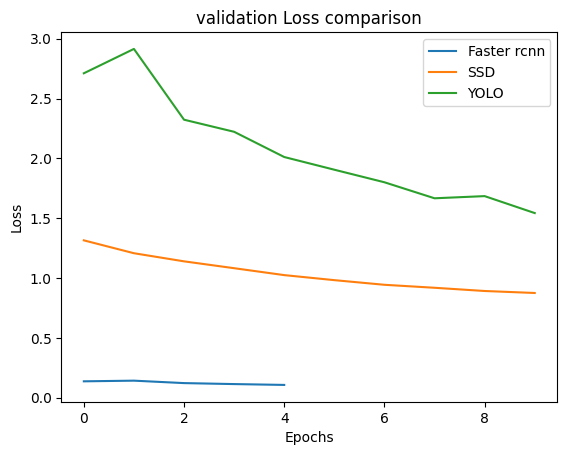

In [37]:
plt.plot(fast_val_loss, label='Faster rcnn')
plt.plot(ssd_val_loss, label='SSD')
plt.plot( yolo_val_loss, label='YOLO')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('validation Loss comparison')
plt.legend()
plt.show()